## It's important to learn from lost business and what we can do to prevent it in the future
Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM).  
They have an application where clients can order taxis, and drivers can accept their rides (offers).  
In this task, we would like to investigate some matching metrics for orders that did not complete successfully, i.e., the customer didn't end up getting a car.

### Read and Explore the Datasets

In [1]:
import pandas as pd

In [2]:
orders = pd.read_csv(filepath_or_buffer="./data/data_orders.csv")
orders.shape

(10716, 8)

In [3]:
# random_state argument ensures that we get the same sample each time we call the method with the same arguments
orders.sample(n=10, random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
10309,00:29:14,-0.966062,51.454821,NaN,3000555146103,4,0,44.0
6705,01:28:45,-0.970472,51.456725,NaN,3000595870644,4,0,121.0
304,08:22:36,-0.916708,51.439852,NaN,3000627783633,9,0,NaN
9143,07:32:27,-0.955580,51.453493,1078.0,3000622140805,4,1,1017.0
10593,04:39:55,-0.946358,51.439779,NaN,3000554645524,4,0,121.0
8654,08:05:02,-0.967327,51.449395,598.0,3000592772077,4,1,48.0
3919,00:21:47,-0.971597,51.457574,NaN,3000624492441,4,0,180.0
4337,20:26:40,-0.971296,51.458115,NaN,3000628755869,4,0,104.0
6931,07:25:39,-0.942301,51.474812,NaN,3000628430595,4,0,44.0
967,13:41:31,-0.952194,51.444067,NaN,3000623591189,9,0,NaN


In [4]:
offers = pd.read_csv(filepath_or_buffer="./data/data_offers.csv")
offers.shape

(334363, 2)

In [5]:
offers.sample(n=10, random_state=42)


,order_gk,offer_id
244971,3000627481054,300052086404
236783,3000631282042,300052342376
22714,3000624367715,300051909011
306983,3000557436646,300050769980
170256,3000588131807,300051201442
316173,3000629756224,300052250019
234398,3000625018320,300051967737
122107,3000629082264,300052196687
60909,3000588606991,300051225443
52998,3000629981908,300052274857


 it's important to note the task here is analyzing and not building a model necessarily, <b> so it's OK to change numerical data to strings </b>

In [6]:
# inner join because orders without an offer may be another issue entirely
df = orders.merge(right=offers, how="inner", on="order_gk")

In [8]:
import numpy as np

# makes this a bit more readable
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
# gotta look this up in the data description
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

# the inplace argument modify the current df rather than returning a new one
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

KeyError: 'is_driver_assigned_key'

In [9]:
# we pass in a dict of old column names as keys and new column names as values
df = df.rename(columns={
    "order_datetime": "order_time"
})

In [11]:
df.sample(n=10, random_state=42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled
13008,03:03:45,-0.966745,51.453236,NaN,3000593295623,NaN,300051413313,No,System Reject
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,6.0,300051090742,No,Client Cancelled
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,NaN,300051125957,No,System Reject
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,113.0,300052078801,No,Client Cancelled
18189,07:52:29,-0.973793,51.458665,479.0,3000587781360,47.0,300051178628,Yes,Client Cancelled


#### Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection.  
#### Analyze the resulting plot. Which category has the highest number of orders?

One straightforward solution to solve this question is to use the groupby method to group the DataFrame by the is_driver_assigned and order_status columns, and then count the rows in each group, i.e., each combination of values for the grouping columns.  
Since both are binary variables (have only two possible values), there are four possible combinations.

In [15]:
# this returns a df, so just index into one column to get the table requested
df.groupby(by=["is_driver_assigned", "order_status"]).count().order_gk

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

A few observations:
1. high number of orders cancelled before a driver is assigned --> implying that maybe customers have waited too long and have decided on an alternative for their transportation needs.  
    a. 13435 orders cancelled by the client 
    b. 9469 rejected by the system.  
2. 8360 client cancellations after a driver has been assigned
    a. four which were rejected by the system, for some reason...

Another interesting approach to this question is to use pivot tables  
Once the pivot table is created (variable df_q1) we call the plot(...) method on it to generate a bar plot, with legend, for a better, visual overview.

In [67]:
df_q1 = df.pivot_table(columns=["is_driver_assigned", "order_status"], values="order_gk", aggfunc="count")
df_q1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

<AxesSubplot: >

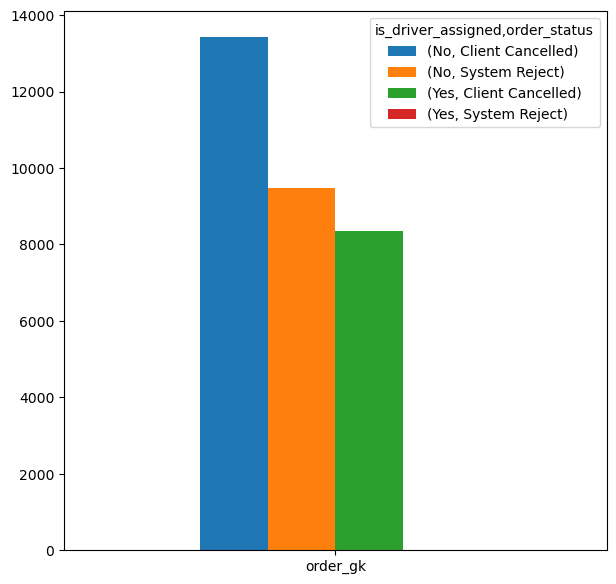

In [68]:
df_q1.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)

#### Plot the distribution of failed orders by hours. 
Is there a trend that certain hours have an abnormally high proportion of one category or another?  
What hours are the biggest fails?  
How can this be explained?

Approach:

1. extract the hour from the order_time column  
    a. format of the order_time is hh:mm:ss.  
2. turn that into a string by calling the .str on the order_time column  
    a. splitting it with : as a delimiter
3. applying a lambda function to return the first token of the split, i.e., the hour.  
4. store this information in a new column, called order_hour.

In [16]:
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [17]:
# print a small sample to make sure that the transformation is correct
df.sample(n=5, random_state=42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled,21
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled,10
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled,09
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled,02
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled,21


<AxesSubplot: title={'center': 'Count of Failed Orders by Hour of Day'}, xlabel='order_hour'>

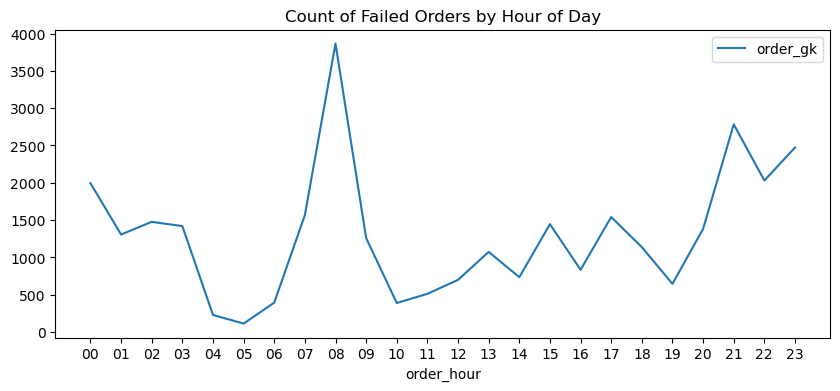

In [18]:
df.groupby(by="order_hour")["order_gk"].count().plot(figsize=(10, 4),
                                                         legend=True,
                                                         xticks=range(0, 24),
                                                         title="Count of Failed Orders by Hour of Day")

A very high number of failed orders is observed in the morning around 7-8 o'clock.
This might point to the fact that the working day starts during those hours, so people are in higher (fast) need of transportation.  
The exact reason for a such high number of failures can't be inferred from this plot, so let's drilled further into the cause for the cancellation

In [19]:
grouped_q2 = df.groupby(by=["order_hour", "is_driver_assigned", "order_status"])["order_gk"].count()
grouped_q2

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
01          No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

Problem: Pandas puts the group-by columns as indices in the resulting DataFrame.  
Solution: Call the reset_index to have the index columns as regular, data columns, and create a new, incrementing integer as an index.

Approach:
1. create a multi-line plot, 
    a. order hour on the horizontal axis
    b. multiple lines that count the number of orders per hour and per fail category.  
2. pivot the table around the order hour column, so that it can be plotted on the y-axis.   
3. decorate the plot with a custom figure size, a title, and a xticks parameter.

<AxesSubplot: title={'center': 'Count of Failed Orders Per Hour and Category'}, xlabel='order_hour'>

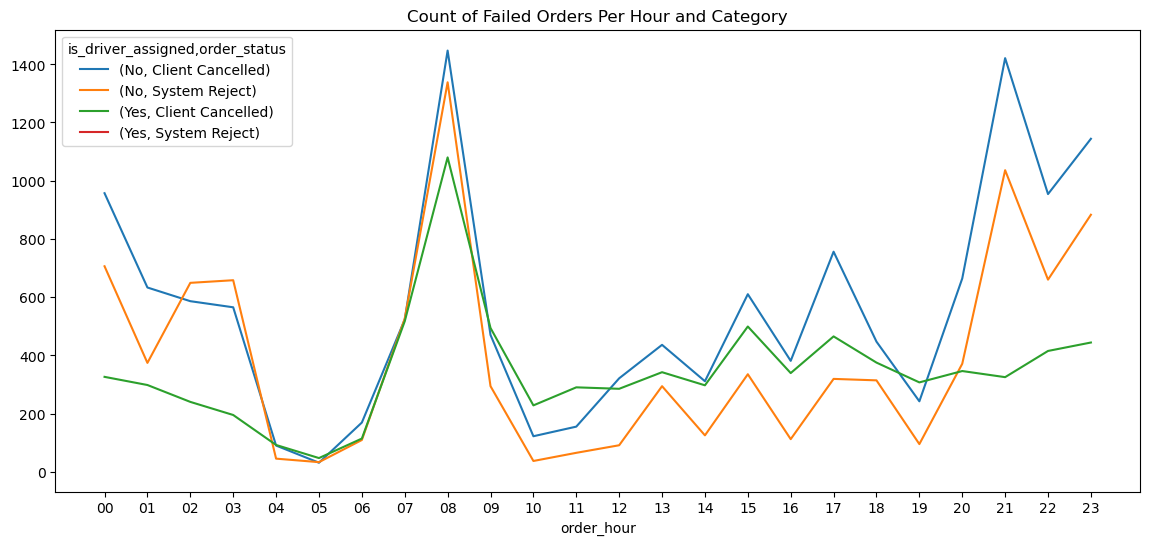

In [73]:
grouped_q2.reset_index().pivot(index="order_hour",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="order_gk").plot(xticks=range(0, 24),
                                                           figsize=(14, 6),
                                                           title="Count of Failed Orders Per Hour and Category")

A few observations:

1. four system rejects with the assigned driver occurred around midnight (see the output of the grouped DataFrame).  
2. rest of the categories follow similar distribution, client cancellations with assigned driver having a substantially lower count during night hours.

### Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?



In [20]:
grouped_q3 = df.groupby(by=["order_hour", "is_driver_assigned"])["cancellations_time_in_seconds"].mean()
grouped_q3

order_hour  is_driver_assigned
00          No                    115.126437
            Yes                   276.082822
01          No                    100.593997
            Yes                   296.312081
02          No                    121.305461
            Yes                   301.466667
03          No                    129.182301
            Yes                   368.682051
04          No                    100.733333
            Yes                   245.250000
05          No                    102.838710
            Yes                   156.617021
06          No                    202.952663
            Yes                   225.508772
07          No                    141.177820
            Yes                   177.640232
08          No                    132.625432
            Yes                   172.896296
09          No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes         

Approach: 
1. call the reset_index() method to transform the grouping columns from indices into regular, data columns.  
2. chain the method calling on the resulting DataFrame with the pivot() method, specify grouping columns and the aggregated values.
3. plot the pivoted DataFrame, and add a custom title, x-ticks, and a figure size for better visual presentation.

<AxesSubplot: title={'center': 'Average Time to Cancellation Per Hour and Driver Assignment'}, xlabel='order_hour'>

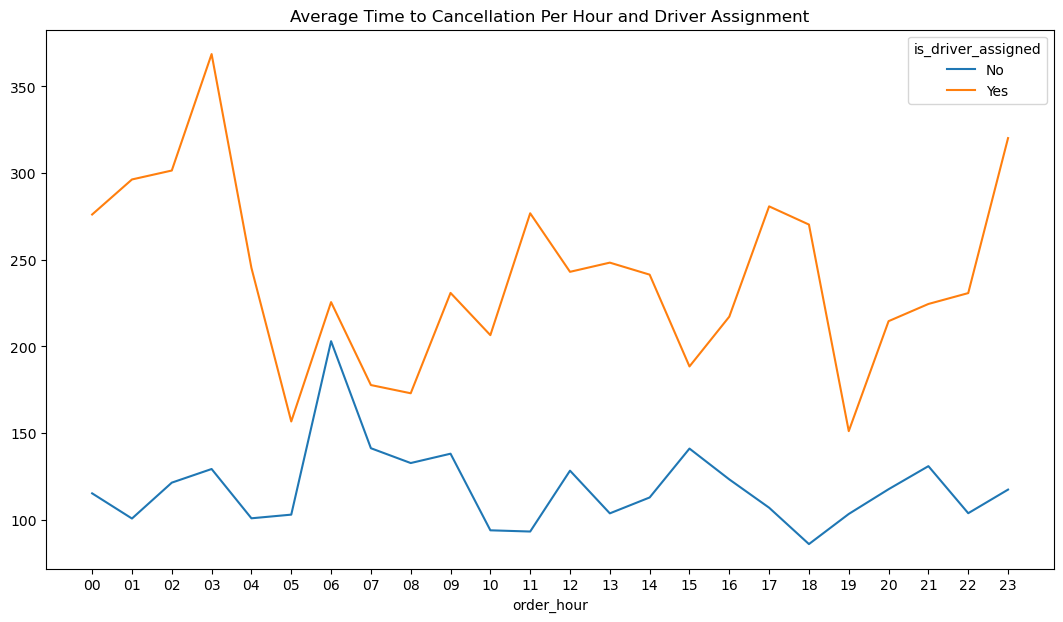

In [75]:
grouped_q3.reset_index().pivot(index="order_hour",
                                   columns="is_driver_assigned",
                                   values="cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment")

A few observations:
1. average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception.  
2. The peak occurs at 3 A.M.  
    a. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

#### Plot the distribution of average ETA by hours. How can this plot be explained?

<AxesSubplot: title={'center': 'Average ETA per hour'}, xlabel='order_hour'>

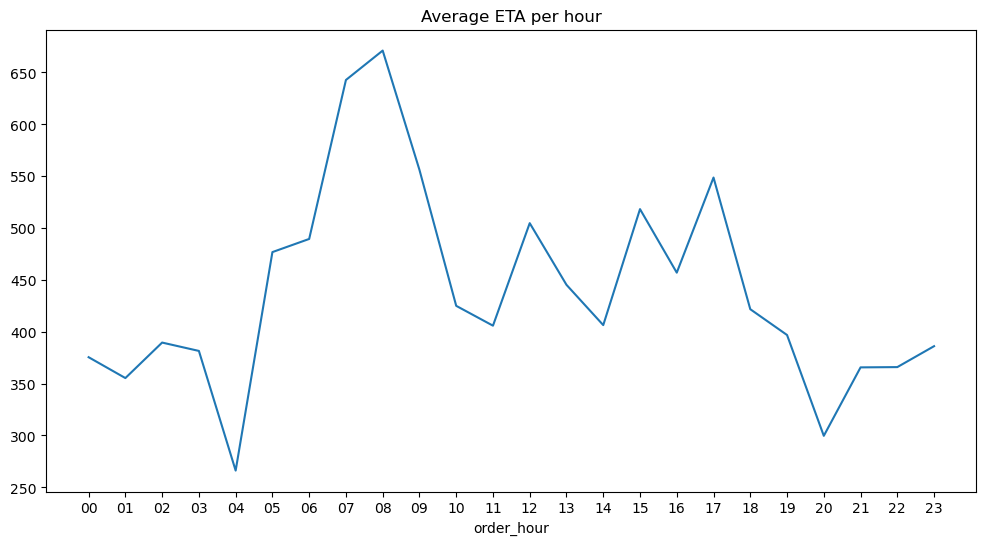

In [76]:
df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(12, 6),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

The line very closely matches the count of failed orders per hour (see two plots above), indicating that the # failed orders increases as the avg waiting time of the client increases.

### Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

- h3 is an open-source framework developed by Uber and a geospatial analysis tool that provides a hexagonal/hierarchical/spatial index to gain insights from large geospatial databases.  
- h3 covers the entire world with hexagons of different sizes.  
- We can map the latitude and longitude attributes that we have in our data to a hexagon ID, an internal h3 ID that points to a specific hexagon of a specific resolution (8, as required in the question).

We will create new column, that we'll call hex_id. Next, what we want to do is to group by the data by the hex_id, and count the number of failed orders in it.

In [21]:
import h3
import folium

use apply(), geo_to_h3(), and given resolution of 8

In [22]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row["origin_latitude"], lng=row["origin_longitude"], resolution=8), axis=1)

In [83]:
grouped_q5 = df.groupby(by="hex_id")["order_gk"].count()
grouped_q5.shape

(139,)

In [84]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5, random_state=42)

,hex_id,order_gk
135,88195d74d1fffff,1
66,88195d2a33fffff,12
31,88195d2941fffff,52
118,88195d2b5dfffff,31
42,88195d2961fffff,5


Find the number of hexes that contain 80% of the orders, by applying a cumulative percentage operation over the order_gk count column in the grouped_q5 DataFrame.  

This consists of the following steps:  
1. Sort the DataFrame by the count.  
2. Find the total number (sum) of failed orders.  
3. Apply the method cumsum to find the cumulative sum of the order-count column.  
4. Divide by the total sum to generate percentages.  
5. Filter to find the row that is closest to 80%.

In [23]:
grouped_q5 = grouped_q5.sort_values(by="order_gk")  # 1
total_orders = grouped_q5["order_gk"].sum()  # 2
grouped_q5["cum_sum"] = grouped_q5["order_gk"].cumsum()  # 3
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders  # 4
grouped_q5[grouped_q5["cum_perc"] <= 80]  # 5

NameError: name 'grouped_q5' is not defined

There are 137 rows in the final output, and 139 rows in the original grouped DataFrame,   
meaning that 137 hexagons contain around 80% of data, and only 2 hexagons contain the other 20%!

#### We will use folium for drawing the map.

In [88]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this present the map best
                 tiles="cartodbpositron")

To be able to draw the hexagons, we need to transform them in a format that is readable by folium, and one solution for that is the geojson package, which contains methods for manipulation of formats (JSONs) that represent geographic objects

In the cell below we apply a custom to_geojson function that transforms the hex_id we have for each hexagon into a proper geojson object that can be read into folium.  
Approach:
1. For each row (each order) we create a geojson.Feature object that stores transformed geometric boundaries for each hexagon. 
2. collect all such objects into a FeatureCollection and dump them into a JSON-formatted string.

In [89]:
import json
import geojson

def to_geojson(row):
    """Transform hex_id into a geojson object."""
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk": row["order_gk"]})


geojsons = grouped_q5.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

To better visualise the hexagons, we are creating a colour map from matplotlib, and taking note of the minimum and the maximum number of orders.  
Note: Make sure to work here with the grouped DataFrame, and not the original data set.

In [90]:
import matplotlib

colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = grouped_q5["order_gk"].max()
min_order_gk = grouped_q5["order_gk"].min()

Final Steps:
1. pass in the GeoJSON string and a lambda style function for it as input arguments into the folium.  
2. GeoJson constructor that creates a proper object that then gets added to the map.
3. Lastly, we plot the map.

In [91]:
folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [92]:
map

## Cool, innit??